In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%%html

<a href="https://jy2014.github.io/EpilepsyPrediction/Home.html" target="_self">Back to the Home Page</a>

# Chapter 4. Predicting Quality of life on Children with Epilepsy History #

_________________________
<font size = "3"> Our second goal is to predict qualify of life for children with history of epilepsy, which might be better answered by data from the National Survey of Children's Health. Because epilepsy is known to cause developmental, social, and cognitive deficits, as well as contribute to injuries, children with epilepsy may have a diminished ability to participate in the same activities as healthy children. Predicting quality of life for children based on demographic, health, and healthcare-related indicators may allow government programs to target children at risk of poor quality of life with social programs and assistance.</font>

<font size = "3">
- [4.1. Construct Response Variable](#4.1.Construct-Response-Variable)
- [4.2. Select Predictor Variables](#4.2.Select-Predictor-Variables)
- [4.3. Model Selection](#4.3.Model-Selection)
- [4.4. Model Comparison](#4.4.Model-Comparison)
- [4.5. Feature Importance and Multicollinearity](#4.5.Feature-Importance-and-Multicollinearity)
- [4.6. Principal Component Analysis](#4.6.Principal-Component-Analysis)
- [4.7. Multiclass Classification](#4.7.Multiclass-Classification)
___

<b><i> please click the button on top of the page to view the code </i></b>

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn import metrics
from sklearn import ensemble
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
from sklearn.linear_model import LogisticRegression as Log
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC as SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA as PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import statsmodels.stats.outliers_influence as sm
%matplotlib inline
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
#### Extract data with Yes/No answers in the epilepsy question
# Import CSV of categorical columns +  Get list
df_cat = pd.read_csv ('Categorical_Column_Names_wState.csv', header = None)
cat = np.array (df_cat.iloc[:, 1])

# FUNCTION: one hot encodes categorical features. AFTER REMOVING epilepsy columns
# INPUTS:
#   categorical_names: list of categorical features
#   df_X; dataframe to encode
#   name: name of final file

def one_hot_encode_categorical(categorical_names, df_X, name):
    # Apply one-hot encoder to categorical columns in the dataset
    
    # remove epilepsy related columns
    categorical_names = categorical_names[categorical_names != 'K2Q42A']
    categorical_names = categorical_names[categorical_names != 'K2Q42B']
    categorical_names = categorical_names[categorical_names != 'K2Q42C']

    # Apply one hot endcoing
    df_X_dummies = pd.get_dummies (df_X, columns = categorical_names)
    
    #print "Dimension of the dataset: ", df_X_dummies.shape
    df_X_dummies.head()
        
    # Save dummy encoded X as CSV
    df_X_dummies.to_csv (name, index=False)

    return df_X_dummies
    
##### LOADING THE OTHER DATASETS
#   df_final: Poverty Level imputed dataset via Random Forest, contains 291 features

### Read dataset with imputed values (Random_Forest)
df_final = pd.read_csv ('imputed_PovertyLevel_RF.csv')
#df_final.shape

# Drop the first two columns as well as ID number (irrelevant)
df_final = df_final.drop(df_final.columns[[0, 1, 2]], axis=1)
#df_final.head()

#   df_y: indicates whether each person has ever had epilepsy
df_y = df_final['K2Q42A'].astype(int)
#df_y.unique()

### Identify non-respondents: create list of rows to drop
rows_to_drop_nonresponse = np.concatenate((np.where(df_y == 6)[0], np.where(df_y == 7)[0]))
df_y.iloc[rows_to_drop_nonresponse]

# Drop nonrespondents from y
df_y_drop = df_y.drop(rows_to_drop_nonresponse)

# Drop epilepsy-related columns
#   df_x: features other than epilepsy
df_x = df_final.drop(['K2Q42A','K2Q42B','K2Q42C'], 1)

# df_x_drop: drops rows where people did not respond about epilepsy status
df_x_drop = df_x.drop(rows_to_drop_nonresponse)

# ONE HOT ENCODE categorical columns (cat) of df_x_drop to make df_x_dummies; SAVE as CSV
#   df_x_dummies: one hot encoded non-epilepsy features
df_x_dummies = one_hot_encode_categorical (cat, df_x_drop, 'X_epilepsy_01_onehot.csv')


___
## 4.1.Construct Response Variable##

<font size = "3">First, we constructed a composite metric of quality of life in children based on questions in our dataset. We selected the following questions and <b>summed together the number of YES responses for each child</b>.

<i>
Do [Child]’s health conditions interfere with [his/her] ability to:
<ul>
    <li> Play with other children?</li>
    <li> Go on outings such as to the park or family gatherings?</li>
    <li> Make friends?</li>
    <li> Attend school on a regular basis?</li>
    <li>Participate in sports, clubs, or other organized activities?</li>
</ul></i>
    
<p></p>
<p>A large number of YES responses indicates a diminished ability to participate in age-appropriate social and physical activities, and may serve as a proxy for quality of life. Then, we plotted the <b>distribution of this response variable within epilepsy children</b>. We noticed that approximately half of epilepsy children had zero YES answers, with the other half of the population distributed among 1, 2, and 3 YES answers. Given this distribution, we first sought to <b>perform binary classify children with 0 vs. 1 or more YES answers</b>. Later, we performed <b>multiclass classification</b>.</p>

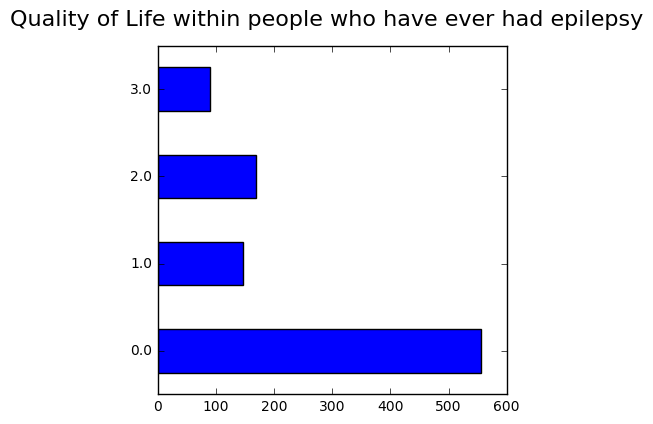

In [5]:
##### QUALITY OF LIFE DATASETS:
# Of people who have ever had epilepsy, assess quality of life by taking sum over QOL measures

### Create dataframe from df_x_drop with ONLY people who have EVER had epilepsy
df_epi = df_x_drop [df_y == 1]
#print df_epi.shape

### Extract Quality of Life Indicators
quality_of_life = df_epi[['K2Q60A', 'K2Q60B', 'K2Q60C', 'K2Q61A', 'K2Q61B', 'K2Q61C']]

# Explore unique values
#print 'Unique values in Quality of Life columns:', pd.Series(quality_of_life.values.ravel()).unique()

# get rid of rows with don't know (6) ~ approx 5 people removed
dont_know_index = quality_of_life.iloc[np.where(np.sum(quality_of_life == 6, axis = 1) > 0)[0]].index
quality_of_life_drop = quality_of_life.drop(dont_know_index)
#print quality_of_life_drop.shape

# Drop these rows from X (df_epi)
df_epi = df_epi.drop(dont_know_index)
#print df_epi.shape

### GET Y: Composite value of quality of life
# Count ones in each row as proxy for QOL (6 questions: 3 asked to small children, 3 to older)
quality_of_life_drop = quality_of_life_drop.replace(-2, 0) # Replace legitimate skips with zero
y_quality = np.sum (quality_of_life_drop, axis = 1)


# Plot counts for each level of quality of life
y_quality_counts = y_quality.value_counts().sort_index()

fig = plt.figure(figsize = (4.5, 4.5))
ax = fig.add_subplot(111)
y_quality_counts.plot (kind = 'barh')
fig.suptitle('Quality of Life within people who have ever had epilepsy', fontsize = 16)

# Binary encoding of quality of life: if greater than threshold_health, designate as poor quality
threshold_health = 0
y_quality_binary = (y_quality > threshold_health).astype (int)

## Save y_quality as CSV
# y_quality_binary.to_csv ('y_QOL_binary.csv', header = False)

___
## 4.2.Select Predictor Variables ##
<p></p>
<font size = "3">Given the large set of predictor variables and our challenges in running models on the full predictor set, we decided to take a <b>subset of 39 predictors related to Demographics, Health, and Health Care Access</b>. This set included questions on other health conditions, age, sex, race, poverty level, health insurance, and government assistance. Providing a model based on these easy-to-access features will also provide convenience on using the model in practice.  </font>


In [6]:
#Save df_epi as CSV
#df_epi_saved = df_epi.to_csv ('X_full_epilepsy_for_QOL_non_encode.csv')

# one hot encode df_epi
df_epi_onehot = one_hot_encode_categorical(cat, df_epi, 'X_full_epilepsy_onehot_forQOL.csv')

## Extract selected variables to have smaller feature set (X_df_select)
demographic = ['AGEYR_CHILD', 'SEX', 'RACER', 'POVERTY_LEVELR' ]
ever_had_health = ['K2Q' +str(i) +'A' for i in range(30, 37) +range(40, 42) + range(43, 47) ]
current_health = ['K2Q' +str(i) +'B' for i in range(30, 37) +range(40, 42) + range(43, 47) ]
current_allergy = ['K2Q' +str(i) +'A' for i in range(47, 52)] 
health_care = ['K3Q0' + str(i) for i in range(1,5) ]
               
var_list = demographic + ever_had_health + current_health + current_allergy + health_care
X_df_select = df_epi[var_list]
#print X_df_select.shape

#X_df_select.to_csv('X_select39_epilepsy_for_QOL_non_encode.csv')

# One hot encode X_df_select
cat_select = list(set(cat).intersection(var_list)) # Find categorical variables in X_df_select
X_df_select_dummies = pd.get_dummies (X_df_select, columns = cat_select)
#X_df_select_dummies.to_csv('X_select39_epilepsy_for_QOL_onehot.csv')


___
##  4.3.Model Selection##
<p></p>
<font size = "3">To perform binary classification on the quality of life of epilepsy patients, we used Stratified K-Fold Cross Validation to tune the parameters of the following models: LDA, QDA, Random Forest, Support Vector Machines, and Logistic Regression. Because our data contains a roughly equal number of children with "good" and "bad" quality of life, we do not have the challenge of class imbalances as we did when predicting epilepsy diagnosis. **Model accuracy is reported below**.

<font size = "2"><b><i>PRESS BUTTON ON TOP OF THE PAGE TO SEE CODE</i></b></font>

In [7]:
## Read quality of life data (one-hot encoded)
## the files were saved from the code above
x = pd.read_csv('X_select39_epilepsy_for_QOL_onehot.csv')
y = pd.read_csv('y_QOL_binary.csv', header = None)
# remove the index column
y = y[1]
# drop the first column of x
x = x.drop(x.columns[[0]], axis = 1)
#x.head()

- <font size = "4"><b>Linear Discriminant Analysis (LDA)</b></font>: 
<p></p>
   <font size = "3">We performed Linear Discriminant Analysis (LDA) using five-fold cross-validation. We found that a 1:1 prior gave the best model, consistent with the balanced classes in our dataset. </font>

In [8]:
# LDA
model = LDA()

# five fold stratified CV
skf = StratifiedKFold(n_splits = 5, shuffle = True)
# tune priors
weights = np.concatenate((np.arange(2,10,1), np.logspace(1,5,5)), axis = 0)
prior_list = [np.asarray([1-1/weights[i], 1/weights[i]]) for i in range(len(weights))]

# tune the model
grid_model = GridSearchCV(model, param_grid = {'priors': prior_list}, 
                          cv  = skf)
grid_model.fit(x, y)
lda = grid_model.best_estimator_
# CV predict
y_pred = cross_val_predict(lda, x, y, cv = skf) 

# print "F1: ", metrics.f1_score(y, y_pred)
# print "Accuracy: ", np.mean(y_pred == y)
# metrics.confusion_matrix(y, y_pred)

- <font size = "4"><b>Quadratic Discriminant Analysis (QDA)</b></font>: 
<p></p>
   <font size = "3">We performed Quadratic Discriminant Analysis (QDA) using five-fold cross-validation.The class priors and regularization parameter were tuned. </font>

In [12]:
#QDA
model = QDA()

# five fold stratified CV
skf = StratifiedKFold(n_splits = 5, shuffle = True)

# get list of priors
weights = np.concatenate((np.arange(2,10,2), np.logspace(1,5,5)), axis = 0)
prior_list = [np.asarray([1-1/weights[i], 1/weights[i]]) for i in range(len(weights))]

# tune regularization param + priors
c = np.logspace (-4, 4, 9)
grid_model = GridSearchCV(model, param_grid = {'priors': prior_list, 'reg_param': c},
                          cv  = skf)
grid_model.fit(x, y)
qda = grid_model.best_estimator_
# CV predict
y_pred = cross_val_predict(qda, x, y, cv = skf) 

# print "F1: ", metrics.f1_score(y, y_pred)
# print "Accuracy: ", np.mean(y_pred == y)
# metrics.confusion_matrix(y, y_pred)

- <font size = "4"><b>Random Forest</b></font>: 
<p></p>
   <font size = "3">We performed random forest using five-fold cross-validation. The maximum depth of the model was tuned. </font>

In [13]:
#Random Forest
model = ensemble.RandomForestClassifier(n_estimators = 50)

# tune depth
depths = np.arange(10, 30, 5).astype(int) 
grid_model = GridSearchCV(model , n_jobs = 5, param_grid = {'max_depth': depths}, 
                          cv  = skf)
grid_model.fit(x, y)
rf = grid_model.best_estimator_
# CV predict
y_pred = cross_val_predict(rf, x, y, cv = skf) 

# print "F1: ", metrics.f1_score(y, y_pred)
# print "Accuracy: ", np.mean(y_pred == y)
# metrics.confusion_matrix(y, y_pred)

- <font size = "4"><b>Support Vector Machine (with RBF kernel)</b></font>: 
<p></p>
   <font size = "3">We also performed Support Vector Machine with RBF kernel on this dataset. RBF kernel was selected mainly due to its compputational efficiency.</font>

In [20]:
# SVM
model = SVC (probability = True)
# use the same reg_param list to tune SVM
grid_model = GridSearchCV(model, param_grid = {'C': c},
                          cv  = skf)
grid_model.fit(x, y)
svm = grid_model.best_estimator_
# CV predict
y_pred = cross_val_predict(svm, x, y, cv = skf) 

# print "F1: ", metrics.f1_score(y, y_pred)
# print "Accuracy: ", np.mean(y_pred == y)
# metrics.confusion_matrix(y, y_pred)

- <font size = "4"><b>Logistic Regression</b></font>: 
<p></p>
   <font size = "3">Weighted logistic regression were performed using five-fold cross-validation, with the regularization parameter $C$ being tuned. </font>

In [14]:
# Log
model = Log()
# use the same reg_param list to tune Log
grid_model = GridSearchCV(model, param_grid = {'C': c},
                          cv  = skf)
grid_model.fit(x, y)
log = grid_model.best_estimator_
# CV predict
y_pred = cross_val_predict(log, x, y, cv = skf) 

# print "F1: ", metrics.f1_score(y, y_pred)
# print "Accuracy: ", np.mean(y_pred == y)
# metrics.confusion_matrix(y, y_pred)

___
## 4.4.Model Comparison##
<p></p>
<font size = 3>After tuning parameters, we found the cross-validation accuracy of each model to be approximately <b>80%</b>. The Receiver Operating Characteristic curve (ROC), which shows the tradeoff between false positive rate and true positive rate, demonstrates that all models perform significantly above chance and have comparable AUCs. Therefore, for a variety of models, <b>we achieved a high classification accuracy and successfully predicted the value of a binary indicator of quality of life in epilepsy patients!</b>.</font> 
<p></p>
<img src="https://cloud.githubusercontent.com/assets/9686980/21193023/b74c4ce4-c1f8-11e6-8dad-0926fbdcaa78.JPG" alt="Model result 2" width = 300 />

<p></p>
<p><font size="3"><b> ROC plot of the models:</b></font></p>

In [21]:
def ROC_plot (y_test, y_pred, col, name, ax):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    ax.plot(false_positive_rate, true_positive_rate, color = col, label= name + ':AUC = %0.2f'% roc_auc)
    ax.plot([0,1],[0,1],'r--')

In [22]:
# split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# train each model on the training set
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)
log.fit(x_train, y_train)
rf.fit(x_train, y_train)
svm.fit(x_train, y_train)

# extract the probability on the testing set
proba_log = log.predict_proba(x_test)[:, 1]
proba_lda = lda.predict_proba(x_test)[:, 1]
proba_qda = qda.predict_proba(x_test)[:, 1]
proba_rf = rf.predict_proba(x_test)[:, 1]
proba_svm = svm.predict_proba(x_test)[:, 1]

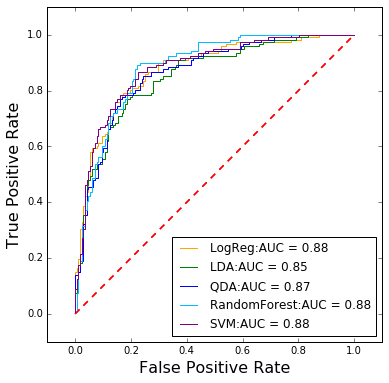

In [22]:
color = ['orange','g', 'b','deepskyblue', 'purple']
names = ['LogReg', 'LDA', 'QDA', 'RandomForest', 'SVM']


fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111) 

ROC_plot(y_test, proba_log, color[0], names[0], ax)
ROC_plot(y_test, proba_lda, color[1], names[1], ax)
ROC_plot(y_test, proba_qda, color[2], names[2], ax)
ROC_plot(y_test, proba_rf, color[3], names[3], ax)
ROC_plot(y_test, proba_svm, color[4], names[4], ax)
    
plt.legend(loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.show()

___
## 4.5.Feature Importance and Multicollinearity ##
<p></p>
<font size = "3">When training predictive models, <b>Multicollinearity</b>, which refers to correlations among predictors, can complicate the process of identifying important predictors and decrease the stability of the models. Large health data sets like the NSCH commonly have multicollinearity because, for example, health conditions and demographics are correlated with each other. While multicollinearity may not affect the overall fit or accuracy of the model, it is difficult to interpret the effect of a given predictor on the response variable if the predictor is collinear with other predictors. 

Given our high classification accuracy, we aimed to identify the most important features and interpret the relationship between patient characteristics and quality of life. To rank features by importance in our best model, the Random Forest, we calculated **feature importance** from the Gini Index, and found that the ranking of feature importances changed each time we fit the dataset. This instability indicated that our dataset may suffer from multicollinearity, so we calculated the **Variance Inflation Factor (VIF)** using the statsmodels package in Python. For the $i$th predictor in a dataset, the VIF is calculated by fitting a least-squares regression on the other predictors and calculating the coefficient of determination ($R^2_i$). 

$$VIF_i = \frac{1}{1 - R^2_i}$$

The VIF describes how much the variance of an estimated regression coefficient is increased because of collinearity. From our boxplot of VIF scores for each of the 39 features, we see that many features have VIF scores larger than 5. Thus, <b>our dataset displays significant multicollinearity, which reduces the interpretability of our model.</b></font>

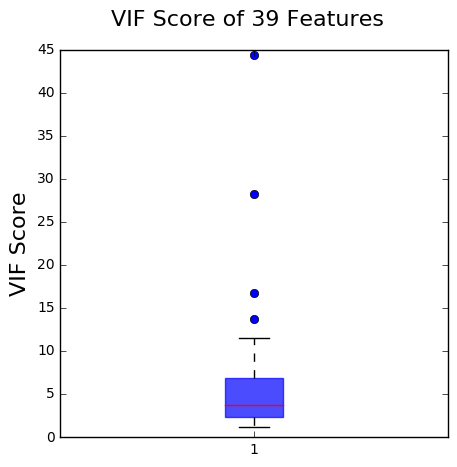

In [23]:
# calculates VIF of 38 epilepsy Quality of Life features, and generates the box plot on the poster
df_x_nonencode = pd.read_csv('X_select39_epilepsy_for_QOL_non_encode.csv')
# Remove first column
df_x_nonencode = df_x_nonencode.drop(df_x_nonencode.columns[0], axis = 1)

variance_inflation_values = np.zeros((df_x_nonencode.shape[1]))
for i in range(df_x_nonencode.shape[1]):
    variance_inflation_values[i] = sm.variance_inflation_factor(df_x_nonencode.values, i)

# Create dataframe with variance inflation values
VIF_df = pd.DataFrame({'VIF': variance_inflation_values}).set_index(df_x_nonencode.columns)

# function to plot VIF
def VIF_plot(VIF):
    fig = plt.figure(figsize = (5, 5))
    bp = plt.boxplot(VIF_df.values, patch_artist=True)
    plt.setp(bp['boxes'], color='blue', alpha = 0.7)
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='o')
    plt.ylabel('VIF Score', fontsize = 16)
    plt.suptitle('VIF Score of 39 Features', fontsize = 16)
    
# plot VIF
VIF_plot(VIF_df)

___
## 4.6.Principal Component Analysis##
<p></p>
<font size = "3">As shown above, our dataset has significant multicollinearity between predictors. To create an orthogonal set of predictors, and thus solve the problem of multicollinearity, we used Principal Components Analysis to transform our (one hot encoded) dataset, and then fit and cross-validated Logistic Regression on 1, 2, or 3 of the first Principal Components. Because all of our models performed with high accuracy, we decided to use Logistic Regression to reduce computation time. The <b>cross-validated accuracy of Logistic Regression using only the first PC was around 80%</b>, which is close to the accuracy of fitting classifiers on the full set of 39 predictors. Because using only one component gives us high accuracy, and our original predictors are highly correlated, this means that the 1st PCA component captures the separation between the classes in addition to capturing variability in predictors. 
<p></p>
<b>Adding additional PC components to our model did not improve accuracy</b>. Therefore, using a single or a few PCA components has comparable accuracy to the above models. </font>

In [24]:
# tried the first 1, 2, 3 PCs, and fit into the logistric regression model
pca = PCA(n_components= 1)
pca.fit(x)
x_reduced = pca.transform(x)

# Log
model = Log()
c = np.logspace (-4,4,9)

skf = StratifiedKFold(n_splits = 5, shuffle = True)
grid_model = GridSearchCV(model, param_grid = {'C': c},
                          cv  = skf)
grid_model.fit(x_reduced, y)
log = grid_model.best_estimator_

y_pred_pca = cross_val_predict(log, x_reduced, y, cv = skf) 

# print "F1: ", metrics.f1_score(y, y_pred_pca)
# print "Accuracy: ", np.mean(y_pred_pca == y)

<img src="https://cloud.githubusercontent.com/assets/9686980/21193031/bbae7744-c1f8-11e6-9473-0c3627893c1b.JPG" alt="Model result 2" width = 300 />

___
## 4.7.Multiclass Classification##
<p></p>
<font size = "3">In addition to the binary response variable, we also performed multiclass classification on the quality-of-life variable by keeping the number of YES questions as classes. Since about 50% of the epilepsy patients had no YES answers, and similar number of patients are in the other three classes, we also faced a problem of imbalance classes in this multiclass classification task. To solve this problem, we performed random forest classifier on the dataset. The maximum depth was tuned first with balanced class weights, then the class weights were further tuned to improve the performance of the model. 
<p></p>
<b>The final model performs with an accuracy of 65.6%. </b> 
<p></p>
<font size = "2"><b><i>PRESS BUTTON ON TOP OF THE PAGE TO SEE CODE</i></b></font>

In [26]:
# Multi-class for Quality Of Life
### Load Datasets
# Y : Quality of Life Composite Metric, takes on values (0,1,2,3)
y = y_quality.reshape(962,)

# X : one hot encoded 39 selected features for quality of life
x = np.array (pd.read_csv('X_select39_epilepsy_for_QOL_onehot.csv'))

# Create Array to store y predictions for each model
y_pred_models = np.zeros((5, y.shape[0]))

# Create list to store best models (models tuned via CV)
best_models_cv = []

# Use Stratified K Fold Cross Validation (to preserve class frequencies)
skf = StratifiedKFold(n_splits = 5, shuffle = True)

In [28]:
### Random Forest, tuning for class_weight
# tune class weight
weight = [1,3,10]
weight = np.array(weight)

# tune the model
accuracy = []
weights = []
for i in weight:
    for j in weight:
        for k in weight:
            for l in weight:
                model = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 10, class_weight={0: i, 1: j, 2: k, 3:l})
                depths = np.arange(10, 30, 5).astype(int) 
                grid_model = GridSearchCV(model , n_jobs = 5, param_grid = {}, 
                          cv  = skf)
                grid_model.fit(x, y)
                rf = grid_model.best_estimator_
                y_pred = cross_val_predict(rf, x, y, cv = skf) 
            
                #print "Accuracy: ", np.mean(y_pred == y)
                accuracy.append(np.mean(y_pred == y))
                weights.append([i,j,k,l])
                metrics.confusion_matrix(y, y_pred)
# best parameters
max_index = np.argmax(accuracy)
optimal_class_weight = weights[max_index]

# print best accuracy
print np.max(accuracy)

### Therefore, we successfully predicted the quality of life in epilepsy patients, determining whether patients have any impairments to quality of life (binary classification) as well as the extent of impairment (multiclass classification).

In [8]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/Diagnosis.html" target="_self">Chapter 3. Predicting Epilepsy Status</a>

In [6]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/Future.html" target="_self">Future Directions</a>

In [7]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/Home.html" target="_self">Back to the Home Page</a>